# Implementing Machine Learning Models to our Data

1. Data loading
2. Data exploration (EDA)
3. Feature extraction and engineering
4. Model training and evaluation

## 1. Load the Data

In [1]:
import pandas as pd

dataset_df = pd.read_csv('data/combined_scam_dataset.csv')

In [2]:
dataset_df.head()

,dialogue,labels,type
0,"caller: hi, this is karen from dr. smith's off...",0,appointment
1,"caller: hi, is this john? recipient: yeah, tha...",0,appointment
2,"caller: hi, i'm calling from xyz medical cente...",0,appointment
3,"caller: hi, i'm calling to confirm your appoin...",0,appointment
4,"caller: hi, i'm calling from dr. smith's offic...",0,appointment


In [3]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5820 entries, 0 to 5819
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   dialogue  5820 non-null   object
 1   labels    5820 non-null   int64 
 2   type      5820 non-null   object
dtypes: int64(1), object(2)
memory usage: 136.5+ KB


In [4]:
dataset_df['labels'].value_counts()

labels
1    2944
0    2876
Name: count, dtype: int64

## 2. Explore the data

This process is important as we will need to understand our data before we can further apply machine learning models to it. Some of our key analyses include:

1. Performing EDA separately for the "Caller" and the "Recipient";
2. Identify the differences in language usage between the two roles;
3. Perform data visualization such as **word clouds** to identify frequently used words for both "Caller" and "Recipient";
4. Plot top unigrams, bigrams, and trigrams for each speaker category;
    - Purpose: To gain insights onto conversational patterns
    - Can identify the frequency of scam-specific words/phrases such as "SSN" or "Congratulations" or "Claim Prize"


### Remove stopwords from the text

In [5]:
from nltk.corpus import stopwords

def remove_stopwords(text: str) -> str:
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

In [6]:
dataset_df['dialogue_processed'] = dataset_df['dialogue'].apply(remove_stopwords)

In [7]:
dataset_df.head()

,dialogue,labels,type,dialogue_processed
0,"caller: hi, this is karen from dr. smith's off...",0,appointment,"caller: hi, karen dr. smith's office. i'm call..."
1,"caller: hi, is this john? recipient: yeah, tha...",0,appointment,"caller: hi, john? recipient: yeah, that's me. ..."
2,"caller: hi, i'm calling from xyz medical cente...",0,appointment,"caller: hi, i'm calling xyz medical center. sc..."
3,"caller: hi, i'm calling to confirm your appoin...",0,appointment,"caller: hi, i'm calling confirm appointment to..."
4,"caller: hi, i'm calling from dr. smith's offic...",0,appointment,"caller: hi, i'm calling dr. smith's office. sc..."


### Separate Caller and Recipient Conversation

In [8]:
import pandas as pd

def extract_caller_and_recipient_texts(dataframe, dialogue_column):
    """
    Extracts texts spoken by 'caller' and 'recipient' from the dialogue column.
    
    Args:
        dataframe (pd.DataFrame): The input dataframe.
        dialogue_column (str): The name of the column with dialogues.
    
    Returns:
        pd.Series, pd.Series: Two Series containing caller and recipient texts.
    """
    caller_texts = []
    recipient_texts = []
    
    for dialogue in dataframe[dialogue_column]:
        # Initialize empty caller and recipient texts
        caller_text = []
        recipient_text = []

        # Split the dialogue into parts based on markers
        parts = dialogue.split("caller:")
        for part in parts[1:]:  # Skip the first split (everything before the first 'caller:')
            if "recipient:" in part:
                # Split between caller and recipient
                caller, recipient = part.split("recipient:", 1)
                caller_text.append(caller.strip())
                recipient_text.append(recipient.strip())
            else:
                # No recipient part, only caller's text
                caller_text.append(part.strip())

        # Append the extracted text to respective lists
        caller_texts.append(" ".join(caller_text))
        recipient_texts.append(" ".join(recipient_text))
    
    # Convert to pandas Series
    return pd.Series(caller_texts, name="caller_texts"), pd.Series(recipient_texts, name="recipient_texts")

In [9]:
caller_texts, recipient_texts = extract_caller_and_recipient_texts(dataset_df, "dialogue")

dataset_df["caller_texts"] = caller_texts
dataset_df["recipient_texts"] = recipient_texts

#### Caller Texts

In [10]:
dataset_df['caller_texts'].head()

0    hi, this is karen from dr. smith's office. i'm...
1    hi, is this john? this is karen from dr. smith...
2    hi, i'm calling from xyz medical center. we ha...
3    hi, i'm calling to confirm your appointment fo...
4    hi, i'm calling from dr. smith's office. we ha...
Name: caller_texts, dtype: object

In [11]:
dataset_df['caller_texts'].tail()

5815    hi, how are you doing today? i'm doing fine. i...
5816    hello there, how's your day going? i'm doing f...
5817    hey, how's it going? i'm doing fine. i've been...
5818    hi there, how's your day going? i'm doing fine...
5819    hello, how's your day going? i'm doing fine. i...
Name: caller_texts, dtype: object

#### Recipient Texts

In [12]:
dataset_df['recipient_texts'].head()

0    oh, hi karen. i think there might be some mist...
1    yeah, that's me. who's this? ah, yeah. i think...
2    actually, i'm not sure. can you tell me what t...
3    oh, i don't recall scheduling an appointment. ...
4    actually, i don't recall making an appointment...
Name: recipient_texts, dtype: object

In [13]:
dataset_df['recipient_texts'].tail()

5815    i'm doing well, thank you. just came back from...
5816    it's been great, thanks. just went to a dance ...
5817    it's been great, thanks. just went to a wine t...
5818    it's been great, thanks. just went to a potter...
5819    it's been great, thanks. just went to a garden...
Name: recipient_texts, dtype: object

### Word Cloud

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_cloud(text_series, title):
    """
    Generates a word cloud from a series of text data.
    
    Args:
        text_series (pd.Series): Series containing text data.
        title (str): Title of the word cloud visualization.
    """
    text = " ".join(text_series.dropna())  # Combine all text into one string
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

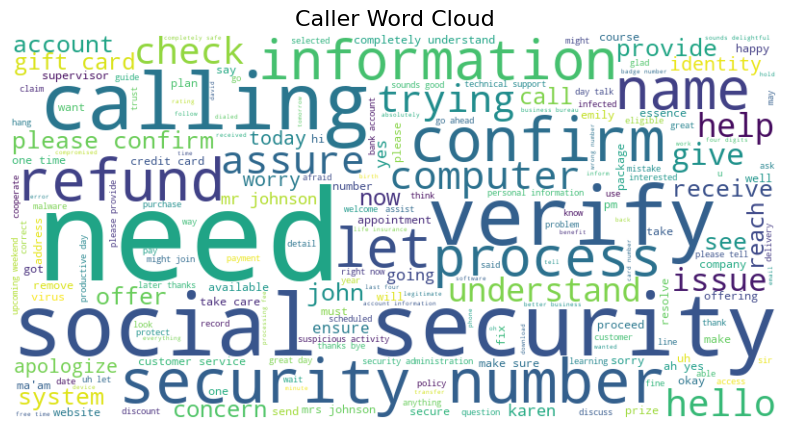

In [15]:
generate_word_cloud(dataset_df["caller_texts"], "Caller Word Cloud")

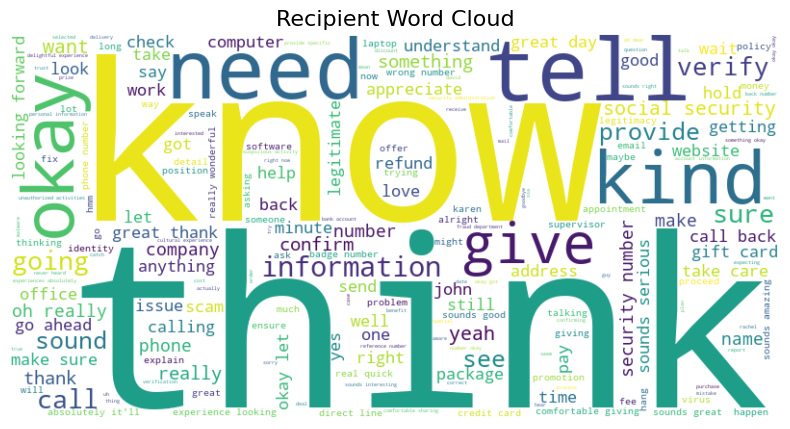

In [16]:
generate_word_cloud(dataset_df["recipient_texts"], "Recipient Word Cloud")

### Most frequently used words for both caller and recipient (Unigram)

The N-gram, is a measure of a sequence of tokens. For example, a 1-gram or unigram is a sequence containing 1 token.

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_words(text_series, top_k=10):
    """
    Identifies the most frequently used words in a series of text data.
    
    Args:
        text_series (pd.Series): Series containing text data.
        top_k (int): Number of top words to extract.
    
    Returns:
        List of tuples: Top words and their counts.
    """
    vectorizer = CountVectorizer()
    word_counts = vectorizer.fit_transform(text_series.dropna())
    word_freq = word_counts.sum(axis=0).A1
    word_features = vectorizer.get_feature_names_out()
    top_words = sorted(zip(word_features, word_freq), key=lambda x: x[1], reverse=True)[:top_k]
    return top_words

In [18]:
import matplotlib.pyplot as plt

def plot_top_words(word_freq, title):
    """
    Plots the top words with their frequencies as a bar chart.
    
    Args:
        word_freq (list of tuples): List of words and their counts.
        title (str): Title of the plot.
    """
    words, counts = zip(*word_freq)  # Unpack words and counts
    plt.figure(figsize=(10, 5))
    plt.barh(words, counts, color="skyblue")
    plt.xlabel("Frequency", fontsize=12)
    plt.ylabel("Words", fontsize=12)
    plt.title(title, fontsize=14)
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.show()

#### Top Caller Words

In [19]:
top_caller_words = get_top_words(dataset_df["caller_texts"], top_k=10)
print("Top Caller Words:", top_caller_words)

Top Caller Words: [('you', np.int64(50392)), ('to', np.int64(42350)), ('the', np.int64(32172)), ('your', np.int64(28584)), ('and', np.int64(27786)), ('we', np.int64(22173)), ('it', np.int64(17078)), ('is', np.int64(16429)), ('can', np.int64(15845)), ('that', np.int64(14053))]


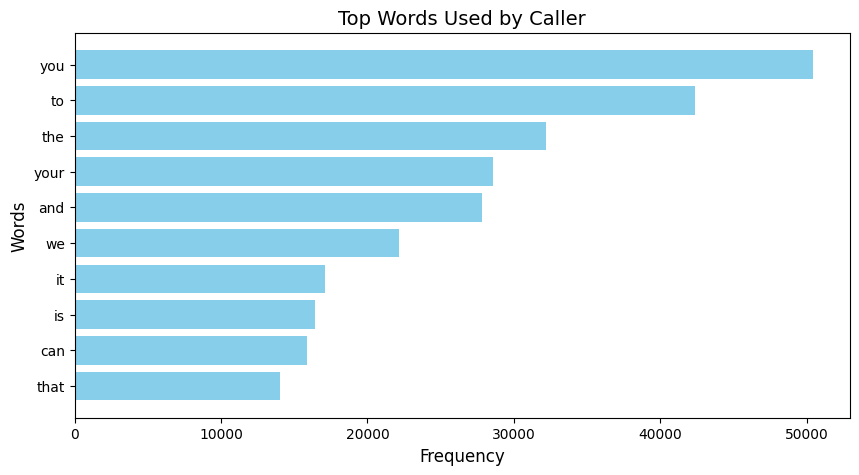

In [20]:
plot_top_words(top_caller_words, "Top Words Used by Caller")

#### Top Recipient Words

In [21]:
top_recipient_words = get_top_words(dataset_df["recipient_texts"], top_k=10)
print("Top Recipient Words:", top_recipient_words)

Top Recipient Words: [('you', np.int64(30002)), ('to', np.int64(18524)), ('the', np.int64(15515)), ('that', np.int64(14800)), ('can', np.int64(14279)), ('me', np.int64(11969)), ('it', np.int64(11378)), ('what', np.int64(11168)), ('and', np.int64(10210)), ('my', np.int64(8957))]


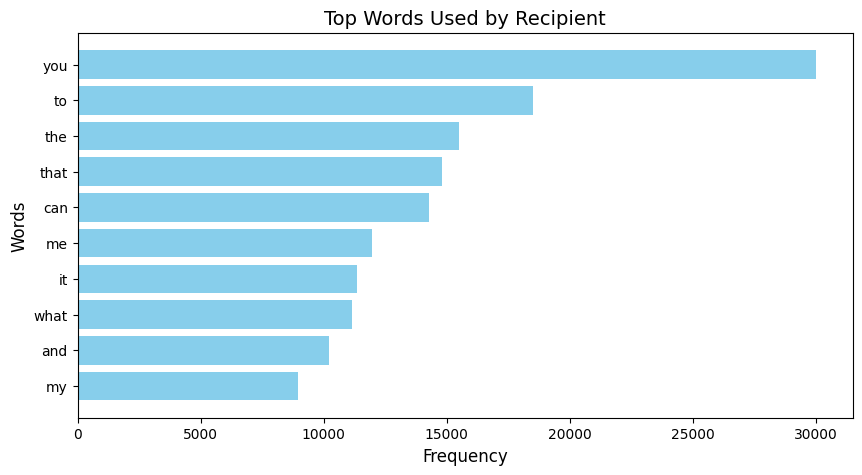

In [22]:
plot_top_words(top_recipient_words, "Top Words Used by Recipient")

### Most frequent bi-grams and tri-grams

This focuses on phrase-level granularity

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Function to get top n-grams
def get_top_ngrams(text_series, n, top_k=10):
    """
    Identifies the most frequently used n-grams in a series of text data.
    
    Args:
        text_series (pd.Series): Series containing text data.
        n (int): The n-gram size (e.g., 2 for bigrams, 3 for trigrams).
        top_k (int): Number of top n-grams to extract.
    
    Returns:
        List of tuples: Top n-grams and their counts.
    """
    vectorizer = CountVectorizer(ngram_range=(n, n))
    ngram_counts = vectorizer.fit_transform(text_series.dropna())
    ngram_freq = ngram_counts.sum(axis=0).A1
    ngram_features = vectorizer.get_feature_names_out()
    top_ngrams = sorted(zip(ngram_features, ngram_freq), key=lambda x: x[1], reverse=True)[:top_k]
    return top_ngrams

# Function to plot n-grams
def plot_top_ngrams(ngrams, title):
    """
    Plots the top n-grams with their frequencies as a bar chart.
    
    Args:
        ngrams (list of tuples): List of n-grams and their counts.
        title (str): Title of the plot.
    """
    ngram_labels, ngram_counts = zip(*ngrams)  # Unpack n-grams and counts
    plt.figure(figsize=(10, 6))
    plt.barh(ngram_labels, ngram_counts, color="lightblue")
    plt.xlabel("Frequency", fontsize=12)
    plt.ylabel("N-Grams", fontsize=12)
    plt.title(title, fontsize=14)
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.show()

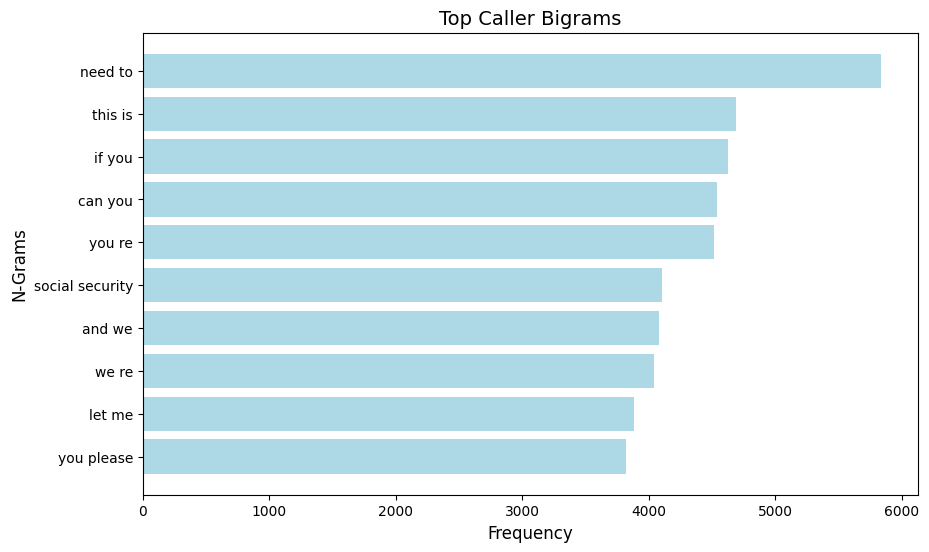

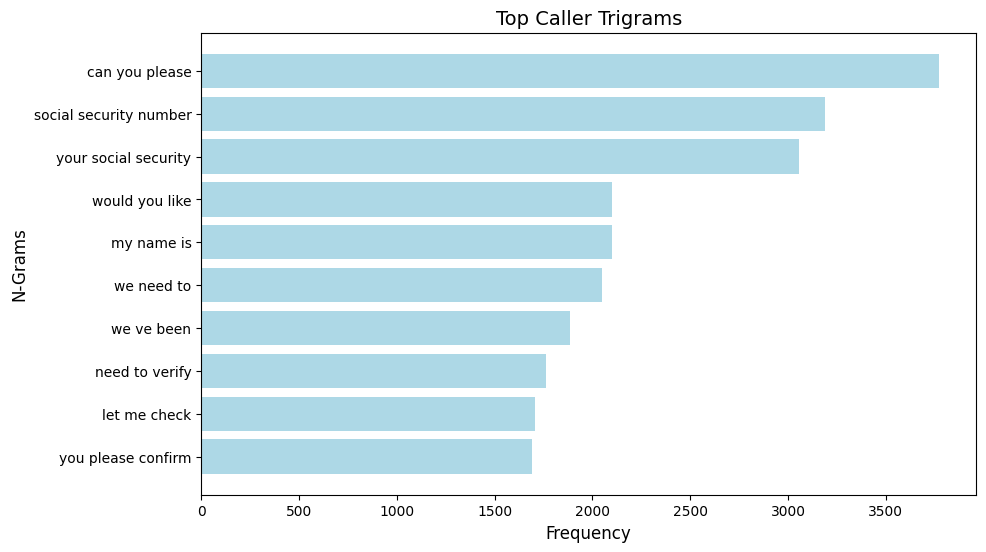

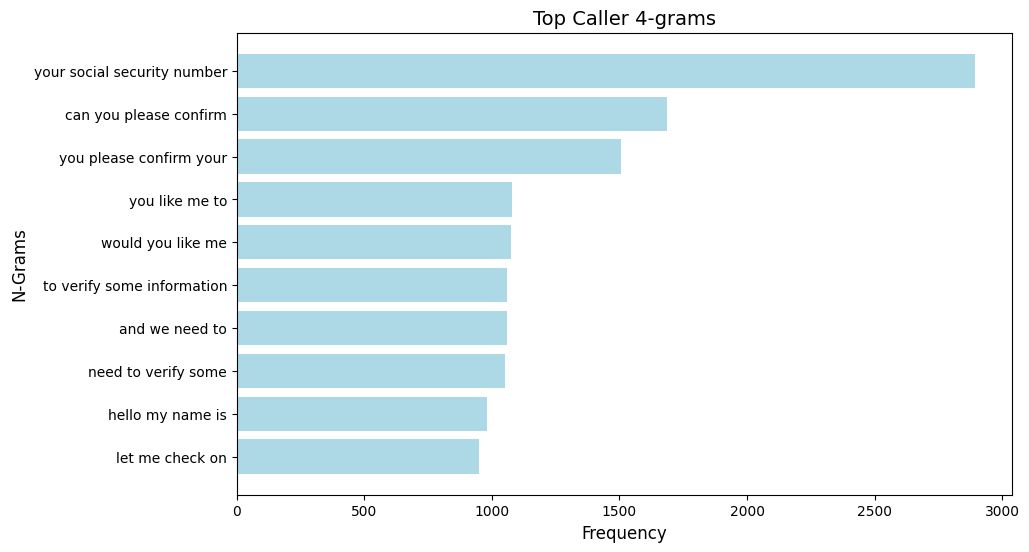

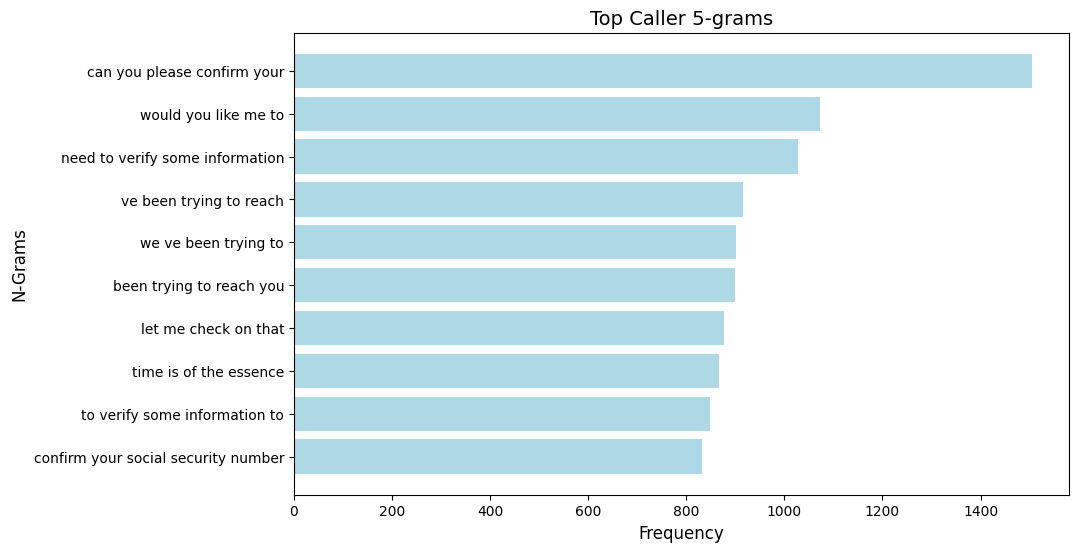

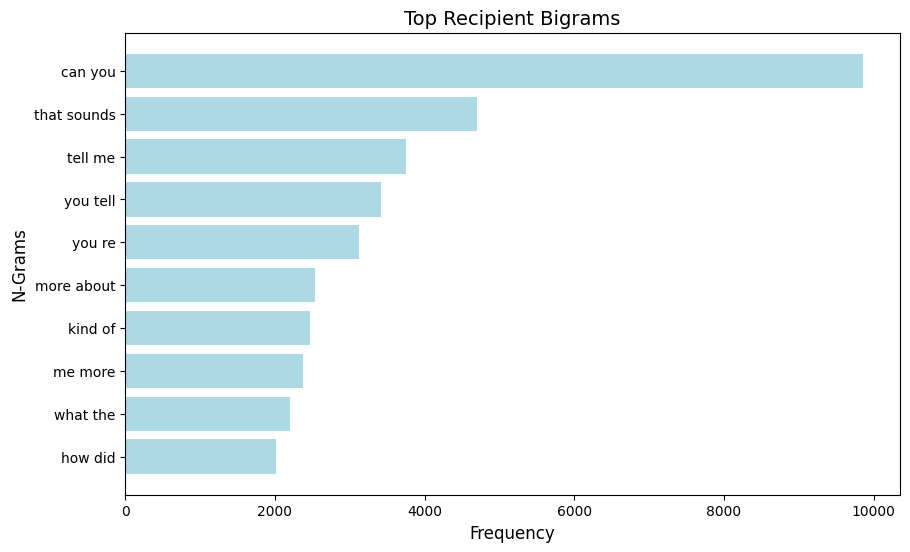

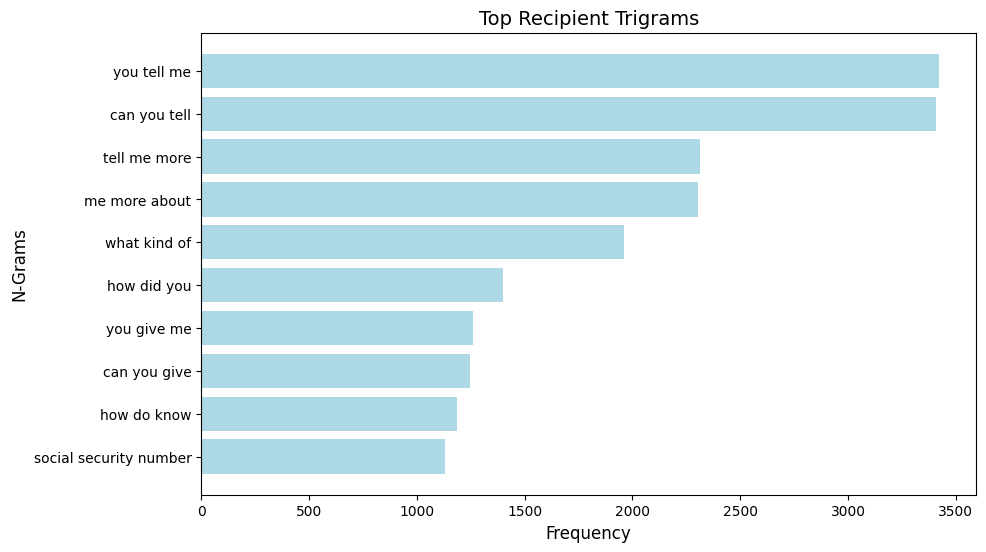

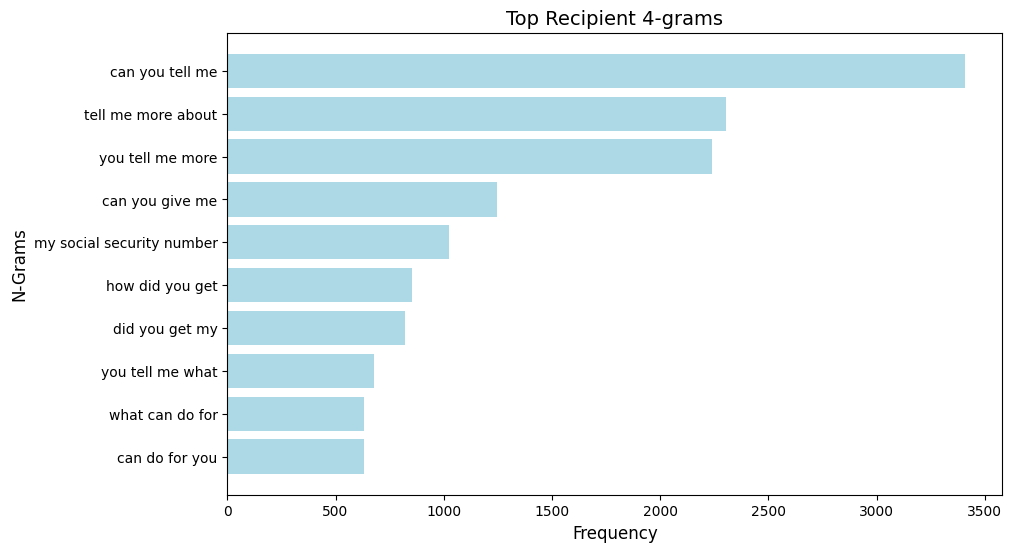

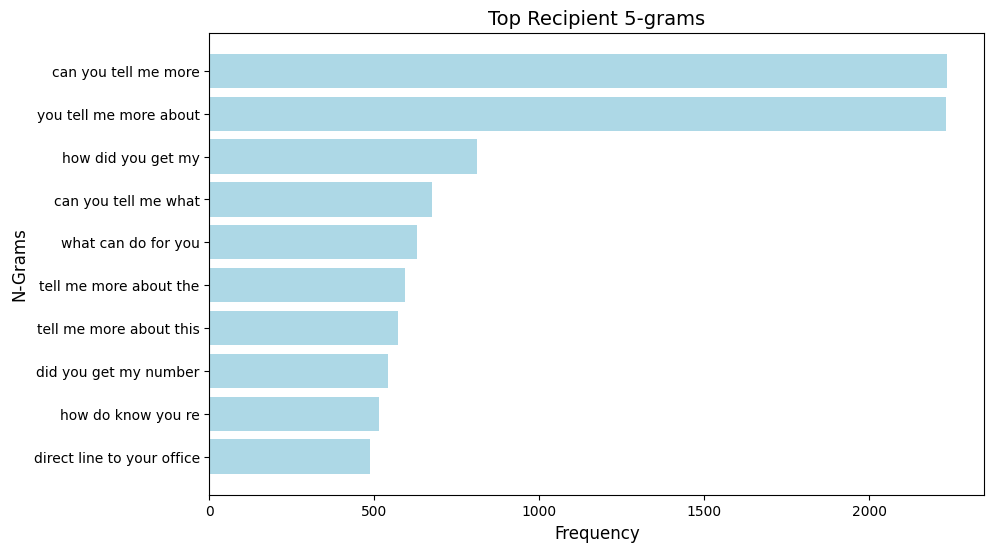

In [24]:
# Replace with your dataset's caller and recipient texts
caller_texts = dataset_df["caller_texts"]  # Ensure this contains the extracted caller texts
recipient_texts = dataset_df["recipient_texts"]  # Ensure this contains the extracted recipient texts

# Generate Bigrams and Trigrams
top_caller_bigrams = get_top_ngrams(caller_texts, n=2, top_k=10)
top_caller_trigrams = get_top_ngrams(caller_texts, n=3, top_k=10)
top_caller_4grams = get_top_ngrams(caller_texts, n=4, top_k=10)
top_caller_pentagrams = get_top_ngrams(caller_texts, n=5, top_k=10)

top_recipient_bigrams = get_top_ngrams(recipient_texts, n=2, top_k=10)
top_recipient_trigrams = get_top_ngrams(recipient_texts, n=3, top_k=10)
top_recipient_4grams = get_top_ngrams(recipient_texts, n=4, top_k=10)
top_recipient_pentagrams = get_top_ngrams(recipient_texts, n=5, top_k=10)
 
# Plot Bigrams and Trigrams for Caller and Recipient
plot_top_ngrams(top_caller_bigrams, "Top Caller Bigrams")
plot_top_ngrams(top_caller_trigrams, "Top Caller Trigrams")
plot_top_ngrams(top_caller_4grams, "Top Caller 4-grams")
plot_top_ngrams(top_caller_pentagrams, "Top Caller 5-grams")
plot_top_ngrams(top_recipient_bigrams, "Top Recipient Bigrams")
plot_top_ngrams(top_recipient_trigrams, "Top Recipient Trigrams")
plot_top_ngrams(top_recipient_4grams, "Top Recipient 4-grams")
plot_top_ngrams(top_recipient_pentagrams, "Top Recipient 5-grams")

#### Recipient's 5-Grams
#### 1. Questions Indicating Clarification or Doubt
- Recipients frequently use phrases like:
  - *"can you tell me more"*
  - *"you tell me more about"*
  - *"how did you get my"*
- These phrases indicate skepticism or curiosity, as recipients often seek clarification or details about the caller's intentions.

#### 2. Focus on Specific Information
- Common phrases include:
  - *"what can do for you"*
  - *"tell me more about the"*
- These patterns suggest that recipients try to gather additional context before making decisions.

#### 3. Skepticism and Inquiry
- Phrases such as:
  - *"how did you get my number"*
  - *"how do know you re"*
- Reflect distrust and a questioning attitude, which are common responses to suspicious calls.

---

#### Caller's 5-Grams
#### 1. Authority and Urgency
- Callers frequently use phrases like:
  - *"can you please confirm your"*
  - *"need to verify some information"*
- These phrases aim to establish authority and create a sense of urgency, aligning with typical scam strategies.

#### 2. Persistence in Communication
- Repeated attempts to contact the recipient are evident in phrases such as:
  - *"we ve been trying to"*
  - *"been trying to reach you"*
- These patterns suggest callers create a narrative of missed communication to pressure recipients into responding.

#### 3. Direct Requests for PII
- Explicit requests for sensitive information are common, as seen in:
  - *"confirm your social security number"*
- These phrases indicate an attempt to extract PII (Personally Identifiable Information), a strong hallmark of scams.

#### 4. Manipulative Language
- Callers use manipulative phrases like:
  - *"time is of the essence"*
- This reflects tactics designed to rush recipients into decisions without careful consideration.

---

#### Comparative Observations
- **Recipient's Behavior**:
  - Recipients focus on clarifying and verifying information.
  - Their responses show skepticism and are inquiry-driven.
- **Caller's Behavior**:
  - Callers use urgency, authority, and persistence to elicit compliance.
  - They frequently make direct requests for sensitive information or actions.

---

#### Conclusion for N-Gram Analysis
- The plots highlight contrasting linguistic strategies:
  - **Recipients**: Seek clarification and express skepticism to protect themselves.
  - **Callers**: Employ authority, urgency, and manipulative language to pressure recipients into compliance.
- These insights can guide feature engineering for the scam detection model, emphasizing linguistic patterns and intent.

### Extract Top Nouns

In [25]:
import spacy
from collections import Counter
import matplotlib.pyplot as plt

# Load SpaCy's English model
nlp = spacy.load("en_core_web_sm")

def extract_top_nouns(text_series, top_k=10):
    """
    Extracts the top nouns from a series of text data.
    
    Args:
        text_series (pd.Series): Series containing text data.
        top_k (int): Number of top nouns to extract.
    
    Returns:
        List of tuples: Top nouns and their counts.
    """
    all_nouns = []
    
    # Iterate through each text entry
    for text in text_series.dropna():
        doc = nlp(text)  # SpaCy's NLP pipeline
        nouns = [token.text.lower() for token in doc if token.pos_ == "NOUN"]
        all_nouns.extend(nouns)
    
    # Count noun frequencies
    noun_counts = Counter(all_nouns)
    return noun_counts.most_common(top_k)

def plot_top_nouns(noun_counts, title):
    """
    Plots the top nouns with their frequencies as a bar chart.
    
    Args:
        noun_counts (list of tuples): List of nouns and their counts.
        title (str): Title of the plot.
    """
    nouns, counts = zip(*noun_counts)  # Unpack nouns and counts
    plt.figure(figsize=(10, 6))
    plt.barh(nouns, counts, color="coral")
    plt.xlabel("Frequency", fontsize=12)
    plt.ylabel("Nouns", fontsize=12)
    plt.title(title, fontsize=14)
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.show()

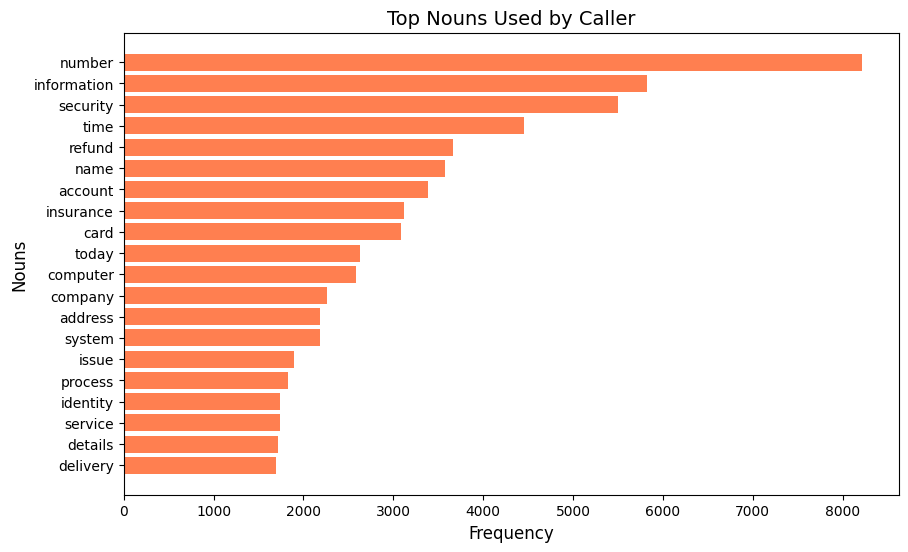

In [26]:
top_caller_nouns = extract_top_nouns(dataset_df["caller_texts"], top_k=20)
plot_top_nouns(top_caller_nouns, "Top Nouns Used by Caller")

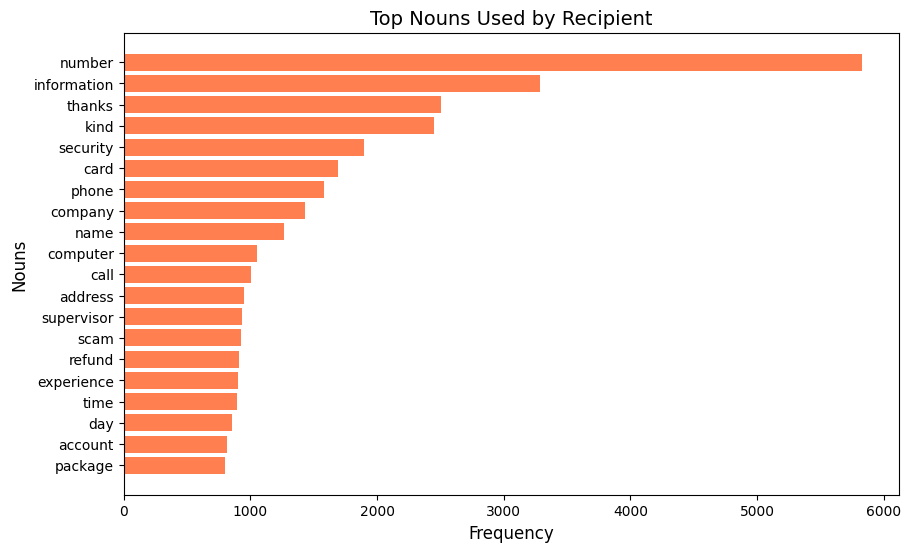

In [27]:
top_recipient_nouns = extract_top_nouns(dataset_df["recipient_texts"], top_k=20)
plot_top_nouns(top_recipient_nouns, "Top Nouns Used by Recipient")

Not much of a difference can be seen between the top nouns used by the caller's and recipients.

## 3. Feature Extraction and Engineering

### A summary of the dataset

Now, the dataset comprises of the following columns:

1. `dialogue` - The original combined phone call conversation
2. `labels` - Represents whether or not the conversation is likely (1) or unlikely (0) a scam call
3. `type` - The type/category of scam
4. `dialogue_processed` - The processed dialogue with the caller/recipient tag standardised
5. `caller_texts` - Only the caller's transcription derived from `dialogue_processed`
6. `recipient_texts` - The recipient's transcription derived from `dialogue_processed`

In [28]:
dataset_df.head()

,dialogue,labels,type,dialogue_processed,caller_texts,recipient_texts
0,"caller: hi, this is karen from dr. smith's off...",0,appointment,"caller: hi, karen dr. smith's office. i'm call...","hi, this is karen from dr. smith's office. i'm...","oh, hi karen. i think there might be some mist..."
1,"caller: hi, is this john? recipient: yeah, tha...",0,appointment,"caller: hi, john? recipient: yeah, that's me. ...","hi, is this john? this is karen from dr. smith...","yeah, that's me. who's this? ah, yeah. i think..."
2,"caller: hi, i'm calling from xyz medical cente...",0,appointment,"caller: hi, i'm calling xyz medical center. sc...","hi, i'm calling from xyz medical center. we ha...","actually, i'm not sure. can you tell me what t..."
3,"caller: hi, i'm calling to confirm your appoin...",0,appointment,"caller: hi, i'm calling confirm appointment to...","hi, i'm calling to confirm your appointment fo...","oh, i don't recall scheduling an appointment. ..."
4,"caller: hi, i'm calling from dr. smith's offic...",0,appointment,"caller: hi, i'm calling dr. smith's office. sc...","hi, i'm calling from dr. smith's office. we ha...","actually, i don't recall making an appointment..."


### Extract the 5-grams from both caller and recipient

From the EDA process, we understand that the 5-grams from both the caller and the recipient provide the most insights on the top phrases and words. We will now extract the 5-grams on a row basis for both the caller and recipient, and then vectorize them using scikit-learn's `CountVectorizer()`.
For now, we will set `max_features` to 5000, which only considers the top 5000 5-grams for each. If this parameter is not set, the number of features can span in the hundreds of thousands!

In [29]:
caller_vectorizer = CountVectorizer(ngram_range=(5, 5), max_features=5000)
recipient_vectorizer = CountVectorizer(ngram_range=(5, 5), max_features=5000)

### What is the `CountVectorizer()`?

The `CountVectorizer()` class is instantiated for both the caller and the recipient. The constructor argument `ngram_range(5, 5)` represents the sequence count to take note of, in this case - a sequence length of 5 tokens. After passing an item in `caller_texts` into the `CountVectorizer()`, the vectorizer converts it into a sparse matrix, with each row representing a row in our original dataset, whereas each column represents the occurrence of the n-gram.

For example, if "Can you please confirm your" is uttered twice by the caller, it would be a matrix like [[2, 0, 0, ..., 0]].

In [30]:
X_caller = caller_vectorizer.fit_transform(dataset_df["caller_texts"])
X_recipient = recipient_vectorizer.fit_transform(dataset_df["recipient_texts"])

### Concatenate both the caller and recipient matrices

Example:

Caller -> (1000, 5000)

Recipient -> (1000, 4000)

Combined -> (1000, 9000)

In [31]:
from scipy.sparse import hstack

X_combined = hstack([X_caller, X_recipient])

In [32]:
X_combined.shape

(5820, 10000)

### Split the dataset in train, validation, and test

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_rest, y_train, y_rest = train_test_split(X_combined, dataset_df["labels"], test_size=0.6, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

## 4. Model Training and Evaluation

### Validating class distribution of the validation set

In [34]:
pd.Series(y_val).value_counts()

labels
1    898
0    848
Name: count, dtype: int64

As you can see, the class distribution is fairly balanced in the validation set.

### Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression()

### Logistic regression results on the validation set

Metrics:

1. Accuracy: *How many total predictions were correct?*
2. Precision: *Out of all predicted scams, how many were actual scams?*
3. Recall: *Out of all actual scams, how many of them were detected?*
4. F1-score: *A balance of precision and recall*
5. Confusion Matrix: *Visual breakdown of the True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)*

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

y_val_pred = logistic_model.predict(X_val) 

accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='binary')
recall = recall_score(y_val, y_val_pred, average='binary')
f1 = f1_score(y_val, y_val_pred, average='binary')
conf_matrix = confusion_matrix(y_val, y_val_pred)
class_report = classification_report(y_val, y_val_pred)

In [37]:
print(f"Validation Set Metrics:\n")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(class_report)

Validation Set Metrics:

Accuracy: 0.9954
Precision: 1.0000
Recall: 0.9911
F1 Score: 0.9955

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       848
           1       1.00      0.99      1.00       898

    accuracy                           1.00      1746
   macro avg       1.00      1.00      1.00      1746
weighted avg       1.00      1.00      1.00      1746



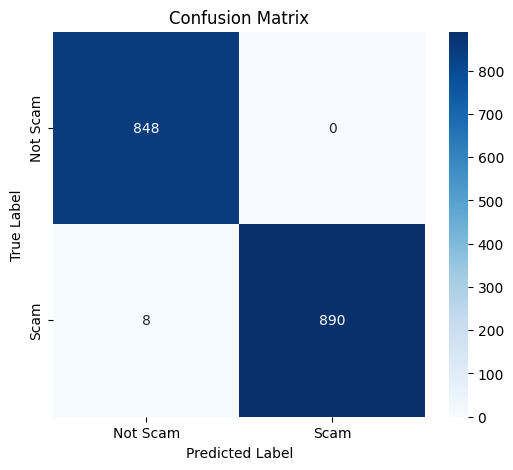

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels=["Not Scam", "Scam"]):
    """
    Plots a heatmap of the confusion matrix.
    
    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        labels (list): Class labels for visualization.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create heatmap
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

    # Labels and title
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    
    # Show plot
    plt.show()

# Example usage with validation set predictions
plot_confusion_matrix(y_val, y_val_pred)  # Ensure y_val and y_val_pred are defined

### Logistic Regression on the test set

Validating class distribution on the test set. As seen below, they are almost evenly distributed.

In [39]:
pd.Series(y_test).value_counts()

labels
0    881
1    865
Name: count, dtype: int64

Test Set Metrics:

Accuracy: 0.9971
Precision: 1.0000
Recall: 0.9942
F1 Score: 0.9971

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       881
           1       1.00      0.99      1.00       865

    accuracy                           1.00      1746
   macro avg       1.00      1.00      1.00      1746
weighted avg       1.00      1.00      1.00      1746



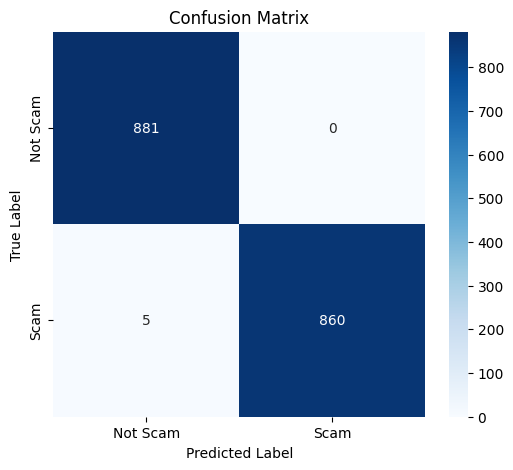

In [40]:
# Make predictions on the test set
y_test_pred = logistic_model.predict(X_test)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='binary')
test_recall = recall_score(y_test, y_test_pred, average='binary')
test_f1 = f1_score(y_test, y_test_pred, average='binary')
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
test_class_report = classification_report(y_test, y_test_pred)

# Print metrics
print(f"Test Set Metrics:\n")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print("\nClassification Report:")
print(test_class_report)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_test_pred)